In [76]:
import pandas as pd
import numpy as np
import os
import sys
import math
import seaborn as sns
from matplotlib import pyplot as plt
import umap.umap_ as umap
import scipy.stats as stats
from tribus import run_tribus, heatmap_for_median_expression, marker_expression, umap_vis, z_score, cell_type_distribution
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import rand_score, accuracy_score, precision_score, f1_score, adjusted_rand_score
from scipy.stats import norm

In [75]:
# if save session
import dill
dill.dump_session('stellar_benchmarking_env.db')

In [ ]:
# restore session
import dill
dill.load_session('stellar_benchmarking_env.db')

In [91]:
# output path
output_path = "C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\output_data\\Tribus_benchmarking\\"

## Analysis on B004 colon region (CL) - 2nd level
We only want to show benchmarking on 2nd level in manuscript...

In [2]:
sample_data = pd.read_csv('C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\input_data\\STELLAR_data_donor_004_upperlevel_CL.csv',low_memory=False)
print(sample_data.columns)
np.shape(sample_data)

Index(['...1', 'MUC2', 'SOX9', 'MUC1', 'CD31', 'Synapto', 'CD49f', 'CD15',
       'CHGA', 'CDX2', 'ITLN1', 'CD4', 'CD127', 'Vimentin', 'HLADR', 'CD8',
       'CD11c', 'CD44', 'CD16', 'BCL2', 'CD3', 'CD123', 'CD38', 'CD90', 'aSMA',
       'CD21', 'NKG2D', 'CD66', 'CD57', 'CD206', 'CD68', 'CD34', 'aDef5',
       'CD7', 'CD36', 'CD138', 'CD45RO', 'Cytokeratin', 'CK7', 'CD117', 'CD19',
       'Podoplanin', 'CD45', 'CD56', 'CD69', 'Ki67', 'CD49a', 'CD163', 'CD161',
       'x', 'y', 'tissue', 'cell_type_A', 'donor', 'unique_region',
       'cell_type_upperlevel'],
      dtype='object')


(110633, 56)

### Run Tribus

In [77]:
# read input files
sample_data = pd.read_csv('C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\input_data\\STELLAR_data_donor_004_upperlevel_CL.csv',low_memory=False)
df = pd.ExcelFile("C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\stellar_logic_gate_cl_benchmarking.xlsx")
logic = pd.read_excel(df, df.sheet_names, index_col=0)

In [80]:
logic

{'Global':              Myeloid  Lymphoid  Stromal  Epithelial
 Marker                                             
 CD163              1        -1       -1          -1
 HLADR              1        -1       -1          -1
 CD16               1         0       -1          -1
 CD206              1        -1       -1          -1
 BCL2              -1         1       -1          -1
 CD69               0         1       -1          -1
 CD3                0         1       -1          -1
 CD127             -1         1       -1          -1
 CD45               1         1       -1          -1
 CD38               0         1        0          -1
 CD90              -1        -1        1           0
 Podoplanin        -1        -1        1           0
 CD34              -1        -1        1           0
 CD56              -1        -1        1           0
 CD49a             -1        -1        1          -1
 aSMA              -1        -1        1          -1
 CDX2               0        -1     

Current benchmarking goal is to get a stable 1st-level classfication
- 1st attempt: use all markers provided in the paper to quantify 1st level (epithelial, Stroma, lymphoid, Myeloid)

<Axes: >

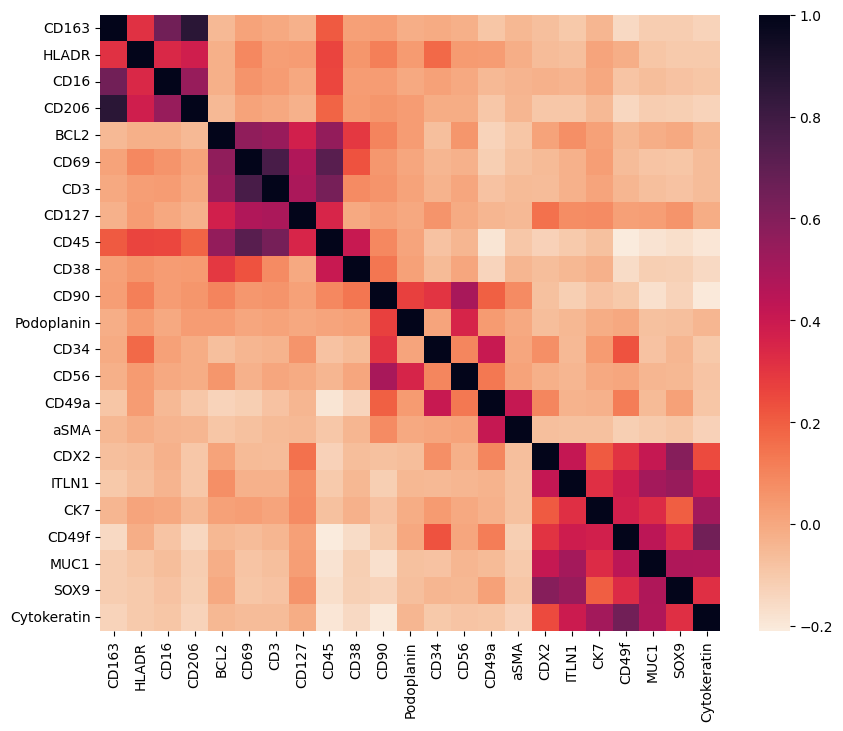

In [5]:
# check the marker correlation matrix we choose for the clustering method
marker_df = sample_data[logic["Global"].index]
plt.figure(figsize=(10,8))
sns.heatmap(marker_df.corr(),cmap=sns.cm.rocket_r)

In [81]:
depth = 2

labels, scores = run_tribus(sample_data, logic, depth=depth, normalization=z_score, 
                            clustering_threshold=5000, undefined_threshold=0.001, other_threshold=0.1, random_state=43)

Global, subsetting done
Myeloid, subsetting done
Lymphoid, subsetting done
Stromal, subsetting done
Epithelial, subsetting done
4.096461947758993 minutes


In [ ]:
# iteration for 5 times without random seed
depth = 1

for i in range(5):
    labels, scores = run_tribus(sample_data, logic, depth=depth, normalization=z_score, 
                            clustering_threshold=5000, undefined_threshold=0.001, other_threshold=0.1, random_state=None)

    Tribus_stat = pd.DataFrame(np.array(np.unique(list(labels["Global"]), return_counts=True)).T, columns=("Cell_type", "Tribus"))
    Truth_stat = pd.DataFrame(np.array(np.unique(list(sample_data["cell_type_upperlevel"]), return_counts=True)).T, columns=("Cell_type", "Ground_Truth"))
    Stat_merged = pd.merge(Tribus_stat, Truth_stat, how="outer", on=["Cell_type"])
    Stat_merged["Tribus"] = pd.to_numeric(Stat_merged["Tribus"])
    Stat_merged["Ground_Truth"] = pd.to_numeric(Stat_merged["Ground_Truth"])

    Stat_merged.plot(x="Cell_type",
        kind='bar',
        stacked=False)
    plt.show()

    for level in labels.columns.values.tolist()[ : -1]: 
        heatmap_for_median_expression(sample_data, labels, logic, level=level, save=False, fname=None,
                                        dpi='figure', transform=z_score, title="{} Marker Expression".format(level),
                                        c_palette=sns.color_palette(['lightsteelblue', 'ivory', 'indianred'], 3),
                                        cmap_='vlag', dendrogram_ratio_=0.1)
    # confusion matrix for first level
    celltype_true = np.array(sample_data["cell_type_upperlevel"]).tolist()
    celltype_pred = np.array(labels["Global"]).tolist()
    cm_labels = np.intersect1d(np.unique(labels["Global"]), np.unique(celltype_true))
    cm = confusion_matrix(celltype_true, 
                        celltype_pred, 
                        labels = cm_labels)
                                                        
    df_cm = pd.DataFrame(cm, index = cm_labels,
                    columns = cm_labels)
    plt.figure(figsize = (len(np.unique(celltype_pred))*0.625, len(np.unique(celltype_pred))*0.5))
    sns.heatmap(df_cm, fmt='g', annot=True, cmap=sns.cm.rocket_r)
    plt.title('Confusion matrix of Tribus')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cmn = pd.DataFrame(cmn, index = cm_labels,
                    columns = cm_labels)
    plt.figure(figsize = (len(np.unique(celltype_pred))*0.625, len(np.unique(celltype_pred))*0.5))
    sns.heatmap(df_cmn, fmt='.2f', annot=True, cmap=sns.cm.rocket_r)
    plt.title('Confusion matrix of Tribus %')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

### Visualize the result

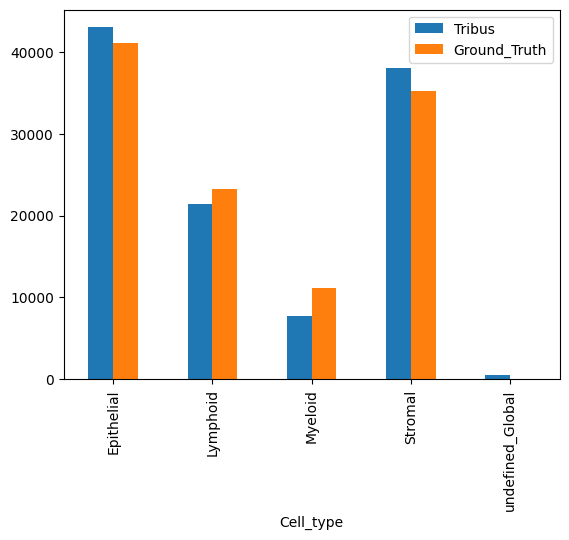

<Figure size 2000x600 with 0 Axes>

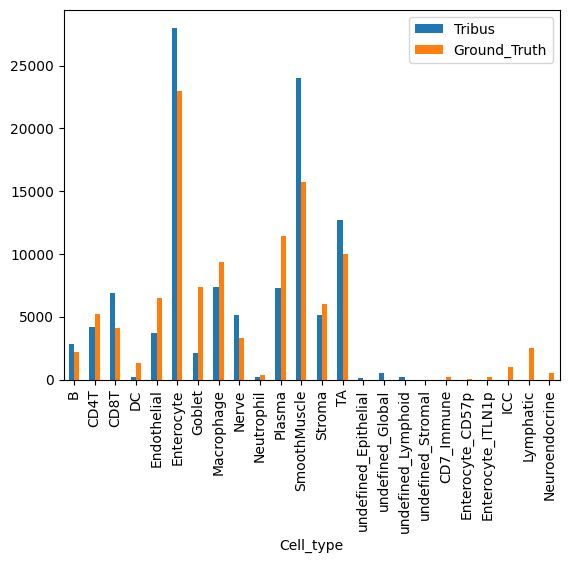

In [97]:
# cell_type_distribution(labels, level="Global")
Tribus_stat = pd.DataFrame(np.array(np.unique(list(labels["Global"]), return_counts=True)).T, columns=("Cell_type", "Tribus"))
Truth_stat = pd.DataFrame(np.array(np.unique(list(sample_data["cell_type_upperlevel"]), return_counts=True)).T, columns=("Cell_type", "Ground_Truth"))
Stat_merged = pd.merge(Tribus_stat, Truth_stat, how="outer", on=["Cell_type"])
Stat_merged["Tribus"] = pd.to_numeric(Stat_merged["Tribus"])
Stat_merged["Ground_Truth"] = pd.to_numeric(Stat_merged["Ground_Truth"])

Stat_merged.plot(x="Cell_type",
        kind='bar',
        stacked=False)

plt.savefig("{}stellar_cl_num_level1.svg".format(output_path))
plt.show()

Tribus_stat = pd.DataFrame(np.array(np.unique(list(labels["final_label"]), return_counts=True)).T, columns=("Cell_type", "Tribus"))
Truth_stat = pd.DataFrame(np.array(np.unique(list(sample_data["cell_type_A"]), return_counts=True)).T, columns=("Cell_type", "Ground_Truth"))
Stat_merged = pd.merge(Tribus_stat, Truth_stat, how="outer", on=["Cell_type"])
Stat_merged["Tribus"] = pd.to_numeric(Stat_merged["Tribus"])
Stat_merged["Ground_Truth"] = pd.to_numeric(Stat_merged["Ground_Truth"])

plt.figure(figsize=(20,6))
Stat_merged.plot(x="Cell_type",
        kind='bar',
        stacked=False)

plt.savefig("{}stellar_cl_num_level2.svg".format(output_path))
plt.show()

In [96]:
for i in labels.columns.values.tolist()[ : -1]: 
    heatmap_for_median_expression(sample_data, labels, logic, level=i, save=True, fname="{}stellar_cl_heatmap_{}.svg".format(output_path,i),
                                    dpi='figure', transform=z_score, title="{} Marker Expression".format(i),
                                    c_palette=sns.color_palette(['lightsteelblue', 'ivory', 'indianred'], 3),
                                    cmap_='vlag', dendrogram_ratio_=0.1)

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

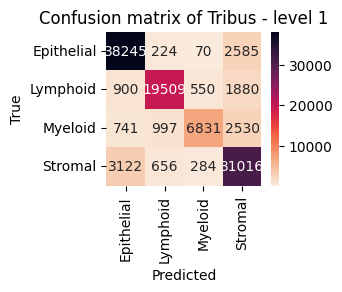

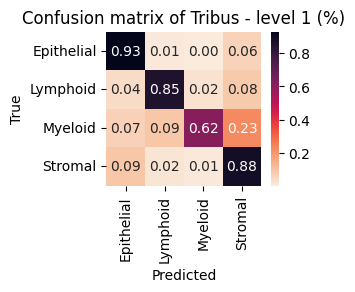

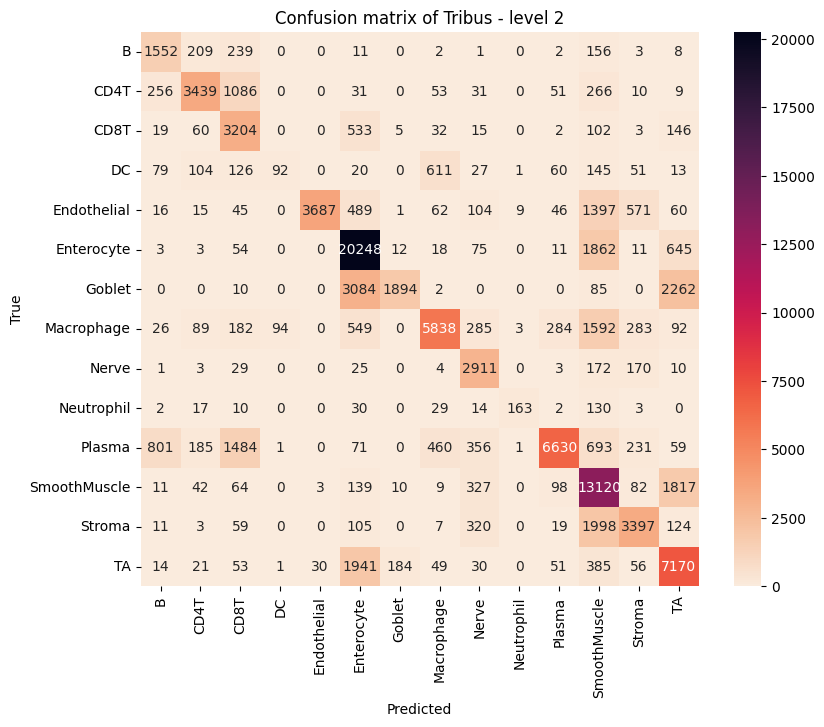

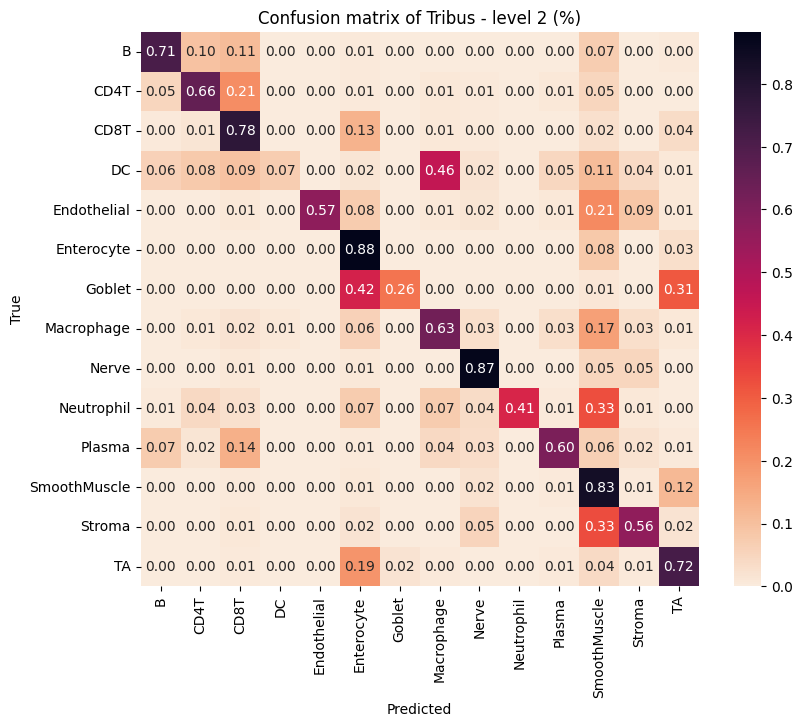

In [95]:
# confusion matrix
plot_depth = 2

if plot_depth == 1: 
    celltype_true = np.array(sample_data["cell_type_upperlevel"]).tolist()
    celltype_pred = np.array(labels["Global"]).tolist()
    cm_labels = np.intersect1d(np.unique(labels["Global"]), np.unique(celltype_true))
    cm = confusion_matrix(celltype_true, 
                        celltype_pred, 
                        labels = cm_labels)
                                                        
    df_cm = pd.DataFrame(cm, index = cm_labels,
                    columns = cm_labels)
    plt.figure(figsize = (len(np.unique(celltype_pred))*0.5, len(np.unique(celltype_pred))*0.4))
    sns.heatmap(df_cm, fmt='g', annot=True, cmap=sns.cm.rocket_r)
    plt.title('Confusion matrix of Tribus - level 1')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.savefig("{}stellar_cl_cm_level_1.svg".format(output_path))
    plt.show()

    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cmn = pd.DataFrame(cmn, index = cm_labels,
                    columns = cm_labels)
    plt.figure(figsize = (len(np.unique(celltype_pred))*0.5, len(np.unique(celltype_pred))*0.4))
    sns.heatmap(df_cmn, fmt='.2f', annot=True, cmap=sns.cm.rocket_r)
    plt.title('Confusion matrix of Tribus - level 1 (%)')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.savefig("{}stellar_cl_cmn_level_1.svg".format(output_path))
    plt.show()
else:
    celltype_true = np.array(sample_data["cell_type_upperlevel"]).tolist()
    celltype_pred = np.array(labels["Global"]).tolist()
    cm_labels = np.intersect1d(np.unique(labels["Global"]), np.unique(celltype_true))
    cm = confusion_matrix(celltype_true, 
                        celltype_pred, 
                        labels = cm_labels)
                                                        
    df_cm = pd.DataFrame(cm, index = cm_labels,
                    columns = cm_labels)
    plt.figure(figsize = (len(np.unique(celltype_pred))*0.5, len(np.unique(celltype_pred))*0.4))
    sns.heatmap(df_cm, fmt='g', annot=True, cmap=sns.cm.rocket_r)
    plt.title('Confusion matrix of Tribus - level 1')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.savefig("{}stellar_cl_cm_level_1.svg".format(output_path))
    plt.show()

    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cmn = pd.DataFrame(cmn, index = cm_labels,
                    columns = cm_labels)
    plt.figure(figsize = (len(np.unique(celltype_pred))*0.5, len(np.unique(celltype_pred))*0.4))
    sns.heatmap(df_cmn, fmt='.2f', annot=True, cmap=sns.cm.rocket_r)
    plt.title('Confusion matrix of Tribus - level 1 (%)')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.savefig("{}stellar_cl_cmn_level_1.svg".format(output_path))
    plt.show()

    celltype_true = np.array(sample_data["cell_type_A"]).tolist()
    celltype_true = [element.replace('Lymphatic', 'Lympatic') for element in celltype_true]
    celltype_true = [element.replace('CD7_Immune', 'CD7_immune') for element in celltype_true]
    celltype_pred = np.array(labels["final_label"]).tolist()
    cm_labels = np.intersect1d(np.unique(labels["final_label"]), np.unique(celltype_true))
    cm = confusion_matrix(celltype_true, 
                        celltype_pred, 
                        labels = cm_labels)
                                                        
    df_cm = pd.DataFrame(cm, index = cm_labels,
                    columns = cm_labels)
    plt.figure(figsize = (len(np.unique(celltype_pred))*0.5, len(np.unique(celltype_pred))*0.4))
    sns.heatmap(df_cm, fmt='g', annot=True, cmap=sns.cm.rocket_r)
    plt.title('Confusion matrix of Tribus - level 2')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.savefig("{}stellar_cl_cm_level_2.svg".format(output_path))
    plt.show()

    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cmn = pd.DataFrame(cmn, index = cm_labels,
                    columns = cm_labels)
    plt.figure(figsize = (len(np.unique(celltype_pred))*0.5, len(np.unique(celltype_pred))*0.4))
    sns.heatmap(df_cmn, fmt='.2f', annot=True, cmap=sns.cm.rocket_r)
    plt.title('Confusion matrix of Tribus - level 2 (%)')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.savefig("{}stellar_cl_cmn_level_2.svg".format(output_path))
    plt.show()

c:\Users\Localadmin_kangzigi\.conda\envs\tribus_new\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Rand score = 0.882474352290847, Accuracy score = 0.6629577070132782, Precision score = 0.6872909442452405, F1 score = 0.6430925378122179


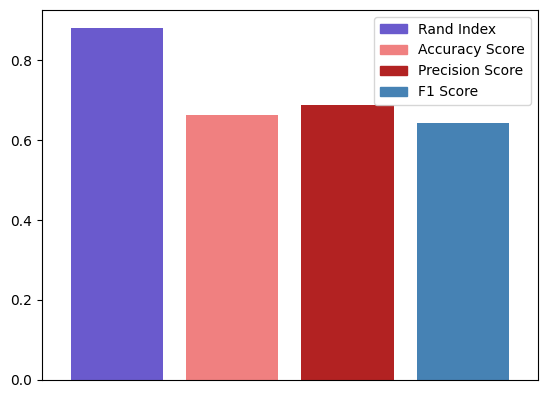

In [98]:
# Calculate average accuracy metrics and visualization with barplot

RI_avg = rand_score(celltype_true, celltype_pred) #between 0-1
AS_avg = accuracy_score(celltype_true, celltype_pred)
PS_avg = precision_score(celltype_true, celltype_pred, average='weighted')
F1_avg = f1_score(celltype_true, celltype_pred, average="weighted")
print("Rand score = {}, Accuracy score = {}, Precision score = {}, F1 score = {}".format(RI_avg, AS_avg, PS_avg, F1_avg))
df = pd.DataFrame([RI_avg, AS_avg, PS_avg, F1_avg], columns=['Value'], 
                  index = ["Rand Index", "Accuracy Score", "Precision Score", "F1 Score"])
df.to_csv("{}stellar_cl_benchmarking_stats_report_all.csv".format(output_path))

colors = {"Rand Index": 'slateblue', "Accuracy Score": 'lightcoral', "Precision Score": 'firebrick', "F1 Score":'steelblue'}
df.plot.bar(y='Value', width = 0.8, legend=False, 
            color=['slateblue', 'lightcoral', 'firebrick', 'steelblue'], rot=0, xticks=[])
metric_labels = ["Rand Index", "Accuracy Score", "Precision Score", "F1 Score"]
handles = [plt.Rectangle((0,0),1,1, color=colors[l]) for l in metric_labels]
plt.legend(handles, metric_labels)

plt.savefig("{}stellar_cl_metrics_average.svg".format(output_path))
plt.show()

                  TN     FP    FN     TP  accuracy
B             107168   1263   650   1552  0.982709
CD4T          104602    772  1820   3439  0.976571
CD8T          102799   3707   923   3204  0.958150
DC            109194     97  1250     92  0.987825
Endothelial   104093     36  2817   3687  0.974212
Enterocyte     79863   7788  2734  20248  0.904893
Goblet        103051    226  5462   1894  0.948587
Macrophage     99730   1531  3534   5838  0.954218
Nerve         105043   2261   418   2911  0.975785
Neutrophil    110219     14   237    163  0.997731
Plasma         98565    643  4795   6630  0.950846
SmoothMuscle   84026  10878  2609  13120  0.878092
Stroma        102858   1720  2658   3397  0.960428
TA             95065   5547  2851   7170  0.924091
              precision    recall  f1-score   support
B              0.551332  0.704814  0.618696    2202.0
CD4T           0.816671  0.653927  0.726294    5259.0
CD8T           0.463609  0.776351  0.580540    4127.0
DC             0.48

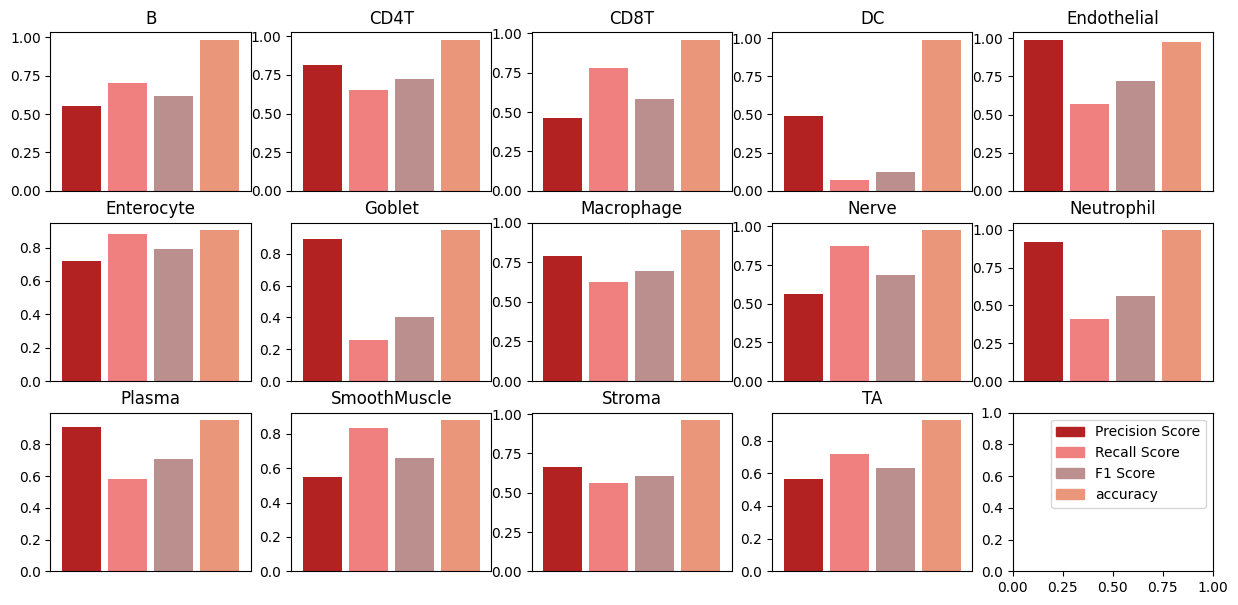

In [99]:
# accuracy metrics per cell type

classes = np.intersect1d(np.unique(celltype_pred), np.unique(celltype_true))

stats_array = metrics.multilabel_confusion_matrix(celltype_true, celltype_pred, labels=classes)
stats_df = pd.DataFrame()
for i in range(len(stats_array)):
    stats_df = pd.concat([stats_df, pd.DataFrame(stats_array[i].flatten()).T])
stats_df.columns = ["TN", "FP", "FN", "TP"]
stats_df.index = [classes]
stats_df["accuracy"] = (stats_df["TN"] + stats_df["TP"]) / (stats_df["TN"] + stats_df["TP"] + stats_df["FN"] + stats_df["FP"]) # in celesta paper they use this way to calculate Rand Index
print(stats_df)
stats_df.to_csv("{}stellar_cl_benchmarking_stats.csv".format(output_path))

report = metrics.classification_report(celltype_true, celltype_pred, labels=classes, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)
report_df.to_csv("{}stellar_cl_benchmarking_stats_report.csv".format(output_path))
# Support is the number of actual occurrences of the class in the specified dataset.

rows = math.ceil(len(np.intersect1d(np.unique(celltype_pred), np.unique(celltype_true))) / 5)
fig, ax = plt.subplots(rows, 5, figsize=(15,7))

for i in range(len(np.intersect1d(np.unique(celltype_pred), np.unique(celltype_true)))): 
    
    celltype = np.intersect1d(np.unique(celltype_pred), np.unique(celltype_true))[i]
    df = report_df.loc[celltype]
    df["accuracy"] = stats_df.iloc[i,-1].tolist()
    df = df[["precision", "recall", "f1-score", "accuracy"]]
    
    colors = {"Precision Score": 'firebrick', "Recall Score": 'lightcoral', "F1 Score":'rosybrown', "accuracy": 'darksalmon'}
    df.plot.bar(y='Value', ax=ax[int(i / 5)][i % 5], width = 0.85, 
                title="{}".format(celltype), legend=False, 
                color=['firebrick', 'lightcoral', 'rosybrown', 'darksalmon'], rot=0, xticks=[])

metric_labels = ["Precision Score", "Recall Score", "F1 Score", "accuracy"]
handles = [plt.Rectangle((0,0),1,1, color=colors[l]) for l in metric_labels]
plt.legend(handles, metric_labels)

plt.savefig("{}stellar_cl_metrics_per_celltype.svg".format(output_path))
plt.show()


C:\Users\Localadmin_kangzigi\AppData\Local\Temp\ipykernel_25864\3316999667.py:46: RuntimeWarning: invalid value encountered in true_divide
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
c:\Users\Localadmin_kangzigi\.conda\envs\tribus_new\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Rand score = 0.882474352290847, Accuracy score = 0.6629577070132782, Precision score = 0.6872909442452405, F1 score = 0.6430925378122179


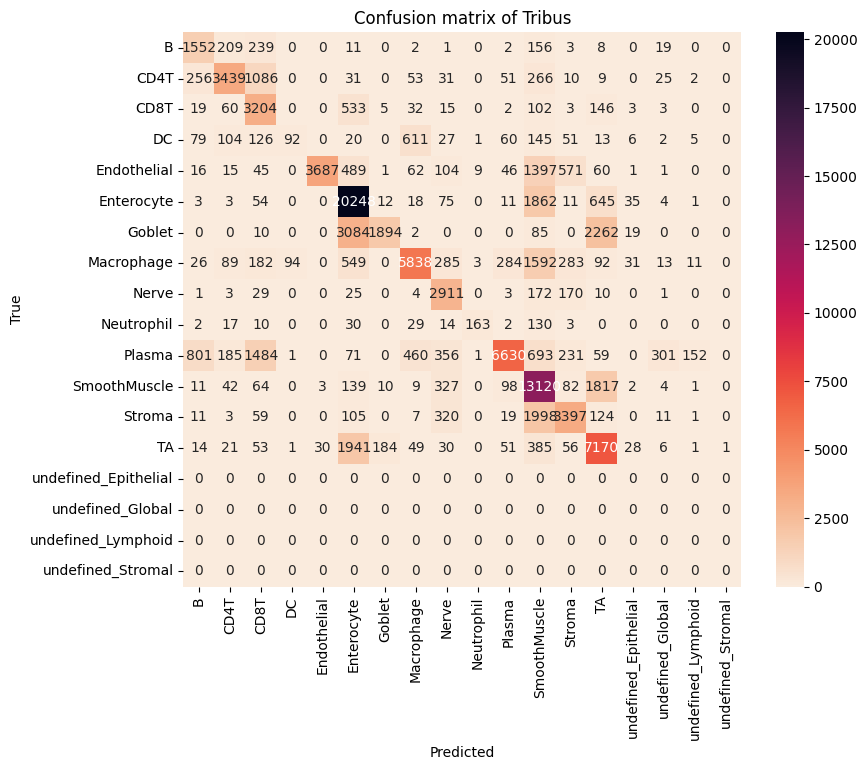

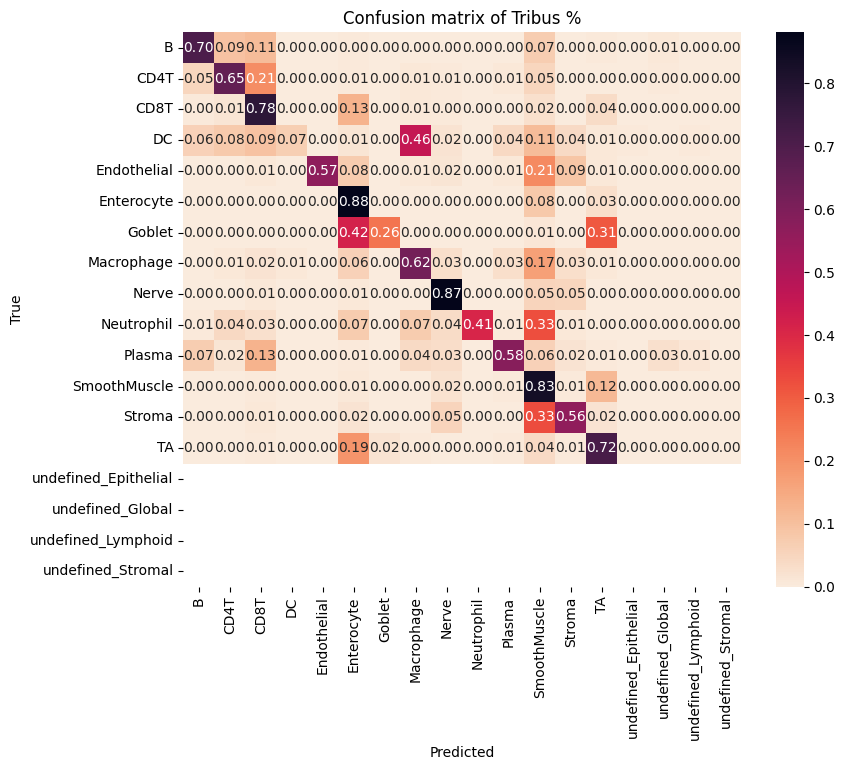

In [37]:
# confusion matrix for all classes in Tribus
if depth == 1: 
    celltype_true = np.array(sample_data["cell_type_upperlevel"]).tolist()
    celltype_pred = np.array(labels["final_label"]).tolist()
    # cm_labels = np.intersect1d(np.unique(labels["final_label"]), np.unique(celltype_true))
    cm_labels = np.unique(labels["final_label"])
    cm = confusion_matrix(celltype_true, 
                        celltype_pred, 
                        labels = cm_labels)
                                                        
    df_cm = pd.DataFrame(cm, index = cm_labels,
                    columns = cm_labels)
    plt.figure(figsize = (len(np.unique(cm_labels))*0.5, len(np.unique(cm_labels))*0.4))
    sns.heatmap(df_cm, fmt='g', annot=True, cmap=sns.cm.rocket_r)
    plt.title('Confusion matrix of Tribus')
    plt.xlabel('Predicted')
    plt.ylabel('True')


    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cmn = pd.DataFrame(cmn, index = cm_labels,
                    columns = cm_labels)
    plt.figure(figsize = (len(np.unique(cm_labels))*0.5, len(np.unique(cm_labels))*0.4))
    sns.heatmap(df_cmn, fmt='.2f', annot=True, cmap=sns.cm.rocket_r)
    plt.title('Confusion matrix of Tribus %')
    plt.xlabel('Predicted')
    plt.ylabel('True')
else:
    celltype_true = np.array(sample_data["cell_type_A"]).tolist()
    celltype_pred = np.array(labels["final_label"]).tolist()
        # cm_labels = np.intersect1d(np.unique(labels["final_label"]), np.unique(celltype_true))
    cm_labels = np.unique(labels["final_label"])
    cm = confusion_matrix(celltype_true, 
                        celltype_pred, 
                        labels = cm_labels)
                                                        
    df_cm = pd.DataFrame(cm, index = cm_labels,
                    columns = cm_labels)
    plt.figure(figsize = (len(np.unique(cm_labels))*0.5, len(np.unique(cm_labels))*0.4))
    sns.heatmap(df_cm, fmt='g', annot=True, cmap=sns.cm.rocket_r)
    plt.title('Confusion matrix of Tribus')
    plt.xlabel('Predicted')
    plt.ylabel('True')


    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cmn = pd.DataFrame(cmn, index = cm_labels,
                    columns = cm_labels)
    plt.figure(figsize = (len(np.unique(cm_labels))*0.5, len(np.unique(cm_labels))*0.4))
    sns.heatmap(df_cmn, fmt='.2f', annot=True, cmap=sns.cm.rocket_r)
    plt.title('Confusion matrix of Tribus %')
    plt.xlabel('Predicted')
    plt.ylabel('True')

RI = rand_score(celltype_true, celltype_pred) #between 0-1
AS = accuracy_score(celltype_true, celltype_pred)
PS = precision_score(celltype_true, celltype_pred, average='weighted')
F1 = f1_score(celltype_true, celltype_pred, average="weighted")
print("Rand score = {}, Accuracy score = {}, Precision score = {}, F1 score = {}".format(RI, AS, PS, F1))

### Save the result

In [90]:
labels.to_csv("{}stellar_cl_benchmarking.csv".format(output_path))